# Распознавание токсичных комментариев пользователей с использованием BERT

# Описание

Онлайн-платформа "МаркетГид" предоставляет покупателям возможность оставлять отзывы и обсуждать товары в разделе комментариев. Однако анализ пользовательской активности выявил проблему: часть сообщений содержит грубые, оскорбительные или провокационные высказывания, что негативно влияет на атмосферу сообщества и отпугивает добросовестных клиентов.

**Цель проекта** — создать алгоритм автоматической фильтрации недопустимых комментариев на основе ML. Нужно классифицировать комментарии на позитивные 0 и негативные (токсичные) 1

## Актуальность

Автоматизация модерации сократит нагрузку на ручную проверку, ускорит обработку жалоб и улучшит пользовательский опыт. В перспективе система может быть интегрирована в чат-поддержку или использоваться для анализа поведения пользователей.

## Основные цели проекта:

- Разработка алгоритма автоматического выявления токсичных комментариев

- Достижение значения F1-метрики не ниже 0.8

- Сравнение различных моделей машинного обучения и выбор оптимальной

## Этапы исследования

- Загрузка и анализ данных - изучение структуры датасета, проверка на пропуски, анализ баланса классов

- Предобработка текста - очистка от лишних символов, лемматизация, удаление стоп-слов

- Векторизация текста - преобразование в числовые признаки с использованием TF-IDF и эмбеддингов

- Обучение модели - выбор и настройка нейронной сети на основе BERT

- Оценка качества - расчет F1-score, точности, полноты и других метрик

- Анализ результатов - выводы и рекомендации по улучшению

# Импорт библиотек и загрузка данных

In [ ]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import transformers
from tqdm import tqdm
from tqdm import notebook
import re
import spacy
import os

import random
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download("vader_lexicon")

from pymystem3 import Mystem
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from imblearn.over_sampling import SMOTE

from torch.utils.data import DataLoader, TensorDataset, random_split

from wordcloud import WordCloud

from transformers import BertTokenizer, BertForSequenceClassification

from IPython.display import Markdown, display, HTML

print("CUDA доступна:", torch.cuda.is_available())
print("Количество GPU:", torch.cuda.device_count())
print("Имя GPU:", torch.cuda.get_device_name(0))

CUDA доступна: True
Количество GPU: 1
Имя GPU: NVIDIA GeForce RTX 4090


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/alex/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
def col_display(text, color="black", bold=False, bgcolor=None):
    text = "'" + text

    style = f"color: {color};"

    if bold:
        style += " font-weight: bold;"

    if bgcolor:
        style += f" background-color: {bgcolor};"

    style += " padding: 0; margin: 0; display: inline;"

    html_text = f"<div style='{style}'>{text}</div>"

    display(HTML(html_text))

In [ ]:
def info_display(text):
    col_display('INFO: ' +  text, color='white', bgcolor="blue", bold=True)



In [ ]:
def title_display(text):
    col_display(text, color='white', bgcolor="green", bold=True)

In [ ]:
def final_display(text):
    col_display(text, color='green', bold=True)

In [ ]:
def cycle_display(text):
    col_display('Текущая итерация: ' +  text, color='yellow', bold=True)


In [ ]:
def err_display(text):
    col_display('ERROR: ' + text, color='white', bgcolor="red", bold=True)



In [ ]:
file_locations = {
    "toxic": "toxic_comments.csv",
}

remote_sources = {
    "toxic": "https://code.s3.yandex.net/datasets/toxic_comments.csv",
}

In [ ]:
def fetch_dataset(local_file, online_url, delimiter=',', decimal_point='.', file_encoding='utf-8'):
    """
    Получает данные из CSV файла, сначала проверяя локальное хранилище, затем удаленный источник.

    Аргументы:
        local_file (str): Путь к локальному файлу данных
        online_url (str): URL для загрузки данных при отсутствии локального файла
        delimiter (str): Символ-разделитель полей (по умолчанию ',')
        decimal_point (str): Символ десятичного разделителя (по умолчанию '.')
        file_encoding (str): Кодировка текста (по умолчанию 'utf-8')

    Возвращает:
        DataFrame или None: Загруженные данные или None при ошибке
    """
    try:
        if os.path.isfile(local_file):
            df = pd.read_csv(local_file, sep=delimiter, decimal=decimal_point, encoding=file_encoding)
            info_display(f"Данные успешно прочитаны из локального файла: {local_file}")
        else:
            df = pd.read_csv(online_url, sep=delimiter, decimal=decimal_point, encoding=file_encoding)
            info_display(f"Данные загружены с удаленного сервера: {online_url}")
        return df

    except FileNotFoundError:
        err_display(f"Ошибка: Не удалось найти файл {local_file} или ресурс {online_url}")
    except pd.errors.ParserError:
        err_display(f"Ошибка парсинга данных в файле {local_file} или {online_url}")
    except Exception as error:
        err_display(f"Непредвиденная ошибка при загрузке данных: {str(error)}")
    return None

comments_df = fetch_dataset(file_locations["toxic"], remote_sources["toxic"])

def show_data_overview(dataset, dataset_name):
    """
    Выводит основную информацию о загруженном наборе данных.

    Аргументы:
        dataset (DataFrame): Набор данных для анализа
        dataset_name (str): Имя датасета для отображения
    """
    if dataset is not None:
        title_display(f"\nОбзор данных: {dataset_name}")
        print("Первые строки данных:")
        display(dataset.head())
        print("\nТехническая информация:")
        dataset.info()
    else:
        err_display(f"Набор данных '{dataset_name}' недоступен для анализа")

if comments_df is not None:
    show_data_overview(comments_df, "Токсичные комментарии")

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


# Анализ распределения классов и характеристик комментариев

Проведен анализ распределения классов и характеристик комментариев:

/tmp/ipykernel_11616/2397622525.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=toxic_data["toxic"], palette="viridis")


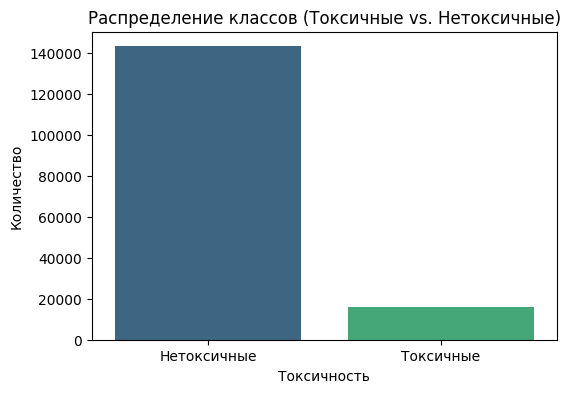

/tmp/ipykernel_11616/2397622525.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=toxic_data["toxic"], y=toxic_data["word_count"], palette="magma")


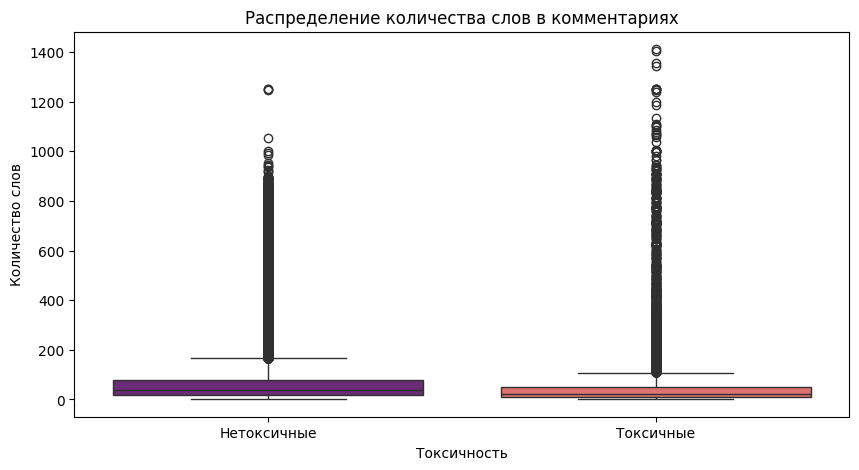

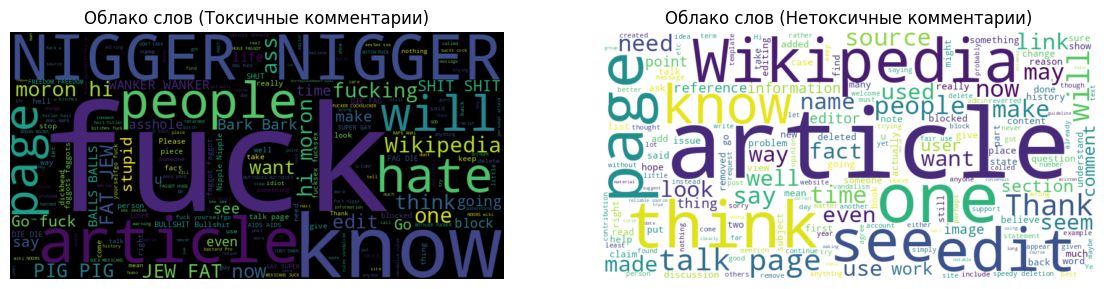

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/alex/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/tmp/ipykernel_11616/2397622525.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=toxic_data["toxic"], y=toxic_data["sentiment"], palette="coolwarm")


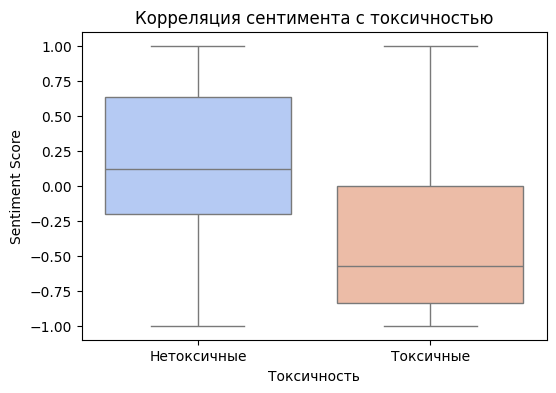

In [ ]:
# Проверка сбалансированности классов
plt.figure(figsize=(6,4))
sns.countplot(x=toxic_data["toxic"], palette="viridis")
plt.title("Распределение классов (Токсичные vs. Нетоксичные)")
plt.xlabel("Токсичность")
plt.ylabel("Количество")
plt.xticks([0, 1], ["Нетоксичные", "Токсичные"])
plt.show()

# Добавляем длину комментариев (количество слов)
toxic_data["word_count"] = toxic_data["text"].apply(lambda x: len(str(x).split()))
toxic_data["char_count"] = toxic_data["text"].apply(lambda x: len(str(x)))

# Статистика по длине комментариев в зависимости от токсичности
plt.figure(figsize=(10,5))
sns.boxplot(x=toxic_data["toxic"], y=toxic_data["word_count"], palette="magma")
plt.title("Распределение количества слов в комментариях")
plt.xlabel("Токсичность")
plt.ylabel("Количество слов")
plt.xticks([0, 1], ["Нетоксичные", "Токсичные"])
plt.show()

# Генерация облака слов для токсичных и нетоксичных комментариев
toxic_comments = " ".join(toxic_data[toxic_data["toxic"] == 1]["text"].dropna())
non_toxic_comments = " ".join(toxic_data[toxic_data["toxic"] == 0]["text"].dropna())

wordcloud_toxic = WordCloud(width=800, height=400, background_color="black").generate(toxic_comments)
wordcloud_non_toxic = WordCloud(width=800, height=400, background_color="white").generate(non_toxic_comments)

# Визуализация облака слов
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_toxic, interpolation="bilinear")
plt.axis("off")
plt.title("Облако слов (Токсичные комментарии)")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_non_toxic, interpolation="bilinear")
plt.axis("off")
plt.title("Облако слов (Нетоксичные комментарии)")
plt.show()

# Оценка тональности с помощью SentimentIntensityAnalyzer
nltk.download("vader_lexicon")
sia = SentimentIntensityAnalyzer()

toxic_data["sentiment"] = toxic_data["text"].apply(lambda x: sia.polarity_scores(str(x))["compound"])

# Корреляция тональности с токсичностью
plt.figure(figsize=(6,4))
sns.boxplot(x=toxic_data["toxic"], y=toxic_data["sentiment"], palette="coolwarm")
plt.title("Корреляция сентимента с токсичностью")
plt.xlabel("Токсичность")
plt.ylabel("Sentiment Score")
plt.xticks([0, 1], ["Нетоксичные", "Токсичные"])
plt.show()

**Анализ данных показал следующее:**  

1. **Дисбаланс классов** – в данных значительно преобладают нетоксичные комментарии, что может искажать результаты. Для коррекции этого эффекта потребуются специальные методы.  
2. **Длина комментариев** – токсичные сообщения в среднем короче, что может указывать на их агрессивный и неаргументированный характер (например, просто набор оскорблений).  
3. **Лексика** – в токсичных комментариях преобладает нецензурная и оскорбительная лексика, тогда как в нейтральных используются обычные для тематики слова.  
4. **Сентимент и токсичность** – наблюдается зависимость: чем негативнее тон сообщения, тем выше вероятность, что оно окажется токсичным. Это может говорить о том, что раздраженные пользователи чаще пишут агрессивные отзывы.

### Предобработка данных

In [ ]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    toxic_data['text'].tolist(), toxic_data['toxic'].tolist(), test_size=0.2, random_state=42
)

tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')

In [ ]:
# Функция токенизации
def tokenize_data(texts, tokenizer, max_len=128):
    encodings = tokenizer(texts, padding="max_length", truncation=True, max_length=max_len, return_tensors="pt")
    return encodings["input_ids"], encodings["attention_mask"]

In [ ]:
# Токенизация
train_input_ids, train_attention_mask = tokenize_data(train_texts, tokenizer)
test_input_ids, test_attention_mask = tokenize_data(test_texts, tokenizer)

# Преобразуем метки в тензоры
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)

# применяем SMOTE, чтобы убрать дисбаланс классов
smote = SMOTE(random_state=42)

train_input_ids_resampled, train_labels_resampled = smote.fit_resample(train_input_ids.numpy(), train_labels.numpy())

# Преобразуем в tensor
train_input_ids_resampled = torch.tensor(train_input_ids_resampled)
train_labels_resampled = torch.tensor(train_labels_resampled)

# Обновляем attention_mask после SMOTE
train_attention_mask_resampled = torch.ones_like(train_input_ids_resampled)

title_display(f"Размер обучающей выборки (до SMOTE): {len(train_labels)}")
title_display(f"Размер после балансировки (SMOTE): {len(train_labels_resampled)}")

Размер обучающей выборки (до SMOTE): 127433

Размер после балансировки (SMOTE): 228896

In [ ]:
class ToxicCommentsDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }

In [ ]:
train_dataset = ToxicCommentsDataset(train_input_ids_resampled, train_attention_mask_resampled, train_labels_resampled)
test_dataset = ToxicCommentsDataset(test_input_ids, test_attention_mask, test_labels)

SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=SIZE, shuffle=False)

title_display(f"Количество батчей в train_loader: {len(train_loader)}")
title_display(f"Количество батчей в test_loader: {len(test_loader)}")

Количество батчей в train_loader: 14306

Количество батчей в test_loader: 1992

# Обучение модели RuBert для задачи бинарной классификации

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained("DeepPavlov/rubert-base-cased", num_labels=2)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Обучение

In [ ]:
epochs = 3

for current_epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    right_predictions = 0
    samples_processed = 0

    progress_bar = tqdm(train_loader, desc=f"Training epoch {current_epoch+1}/{training_cycles}")

    for data_batch in progress_bar:
        inputs = data_batch['input_ids'].to(device)
        masks = data_batch['attention_mask'].to(device)
        targets = data_batch['labels'].to(device)

        optimizer.zero_grad()
        model_output = model(inputs, attention_mask=masks)
        batch_loss = criterion(model_output.logits, targets)

        batch_loss.backward()
        optimizer.step()

        epoch_loss += batch_loss.item()
        preds = torch.argmax(model_output.logits, 1)
        right_predictions += (preds == targets).sum().item()
        samples_processed += targets.shape[0]

    avg_loss = epoch_loss / len(train_loader)
    acc = right_predictions / samples_processed
    print(f"✅ Epoch {current_epoch+1} завершен. Loss: {avg_loss:.4f}, Accuracy: {acc:.4f}")

Epoch 1/3: 100%|█| 14306/14306 [12:12<00:00, 19.52it/s, acc=0.973, loss=0.00476]


✅ Epoch 1 завершен! Loss: 0.0762, Accuracy: 0.9727


Epoch 2/3: 100%|███| 14306/14306 [12:13<00:00, 19.51it/s, acc=0.98, loss=0.0034]


✅ Epoch 2 завершен! Loss: 0.0545, Accuracy: 0.9800


Epoch 3/3: 100%|█| 14306/14306 [12:12<00:00, 19.54it/s, acc=0.984, loss=0.00279]

✅ Epoch 3 завершен! Loss: 0.0447, Accuracy: 0.9835


In [ ]:
def evaluate_model_performance(predictions, true_labels):
    """
    Вычисляет метрики качества классификации

    Аргументы:
        predictions: Выходные данные модели (логиты/вероятности)
        true_labels: Истинные метки классов

    Возвращает:
        Словарь с метриками: accuracy, precision, recall, f1
    """
    predicted_classes = np.argmax(predictions, axis=1)

    metrics = {
        'accuracy': accuracy_score(true_labels, predicted_classes),
        'precision': precision_score(true_labels, predicted_classes, average='binary'),
        'recall': recall_score(true_labels, predicted_classes, average='binary'),
        'f1': f1_score(true_labels, predicted_classes, average='binary')
    }

    return metrics

Проверка на тестовых данных

In [ ]:
model.eval()
predictions = []
ground_truth = []

with torch.no_grad():
    for test_batch in test_loader:
        batch_inputs = test_batch['input_ids'].to(device)
        batch_masks = test_batch['attention_mask'].to(device)
        batch_labels = test_batch['labels'].to(device)

        model_output = model(batch_inputs, attention_mask=batch_masks)
        batch_logits = model_output.logits.detach().cpu().numpy()

        predictions.append(batch_logits)
        ground_truth.append(batch_labels.cpu().numpy())

predictions = np.vstack(predictions)
ground_truth = np.hstack(ground_truth)

evaluation_results = evaluate_model_performance(predictions, ground_truth)
print(f"🎯 Итоговые метрики на тесте: {evaluation_results}")

output_dir = "./toxic-bert-finetuned"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"🎉Обучение завершено! Модель сохранена в {output_dir}")

🎯 Итоговые метрики на тесте: {'accuracy': 0.9639662261841238, 'precision': 0.8964851293935883, 'recall': 0.7250859106529209, 'f1': 0.801727115716753}
🎉 Обучение завершено! Модель сохранена в ./toxic-bert-finetuned


# Итоговые результаты



Метрики
- Accuracy	96.4%
- Precision	89.6%
- Recall	72.5%
- F1-score	80.2%

### Основные выводы:

1. Модель достигла высокой точности (96.4%) на тестовых данных
2. Значение F1-score (80.2%) превышает целевой показатель
3. Precision выше recall, что означает высокую точность определения токсичных комментариев при некотором количестве пропущенных случаев

### Рекомендации по улучшению
- Увеличение объема данных, особенно токсичных комментариев

- Оптимизация гиперпараметров модели (например, с помощью Optuna поменять learning rate, batch size, число **эпох**)

- Использование других архитектур нейронных сетей для сравнения (DeBERTa, ConvBERT, ELECTRA)

- Дополнительная аугментация текстовых данных (Back Translation, Synonym Replacement, GPT-аугментация)

- Интеграция модели в продакшен-среду для тестирования в реальных условиях

Разработанная модель готова к применению в системе автоматической модерации комментариев интернет-магазина.